In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Tomato_Cases",
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

class_names = dataset.class_names  # store before splitting
n_classes = len(class_names)

Found 16011 files belonging to 10 classes.


In [4]:
class_names = dataset.class_names
class_names

['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [5]:
len(dataset)

501

In [6]:
# this will take 1 batch, i.e, 32 images
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[7 7 4 7 0 7 0 5 6 3 6 7 7 7 0 9 7 2 6 6 2 7 4 9 4 7 7 6 1 0 6 0]


In [7]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch[0].numpy)

<bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(256, 256, 3), dtype=float32, numpy=
array([[[149., 150., 144.],
        [147., 148., 142.],
        [146., 147., 141.],
        ...,
        [105., 105., 105.],
        [103., 103., 103.],
        [105., 105., 105.]],

       [[150., 151., 145.],
        [149., 150., 144.],
        [147., 148., 142.],
        ...,
        [104., 104., 104.],
        [102., 102., 102.],
        [104., 104., 104.]],

       [[147., 148., 142.],
        [147., 148., 142.],
        [146., 147., 141.],
        ...,
        [107., 107., 107.],
        [110., 110., 110.],
        [114., 114., 114.]],

       ...,

       [[141., 146., 140.],
        [139., 144., 138.],
        [137., 142., 136.],
        ...,
        [ 87.,  91.,  92.],
        [ 91.,  95.,  96.],
        [ 94.,  98.,  99.]],

       [[139., 144., 138.],
        [137., 142., 136.],
        [134., 139., 133.],
        ...,
        [ 98., 102., 103.],
        [103., 107., 108.],
       

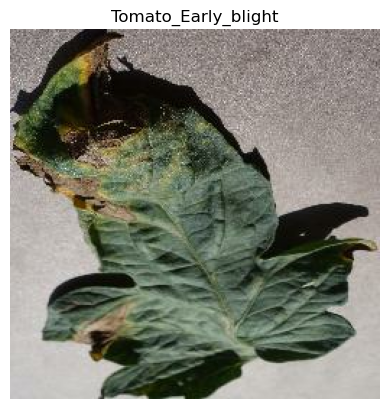

In [8]:
for image_batch, label_batch in dataset.take(1):
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    # displaying label
    plt.title(class_names[label_batch[0]])
    # turning off the axis
    plt.axis("off")

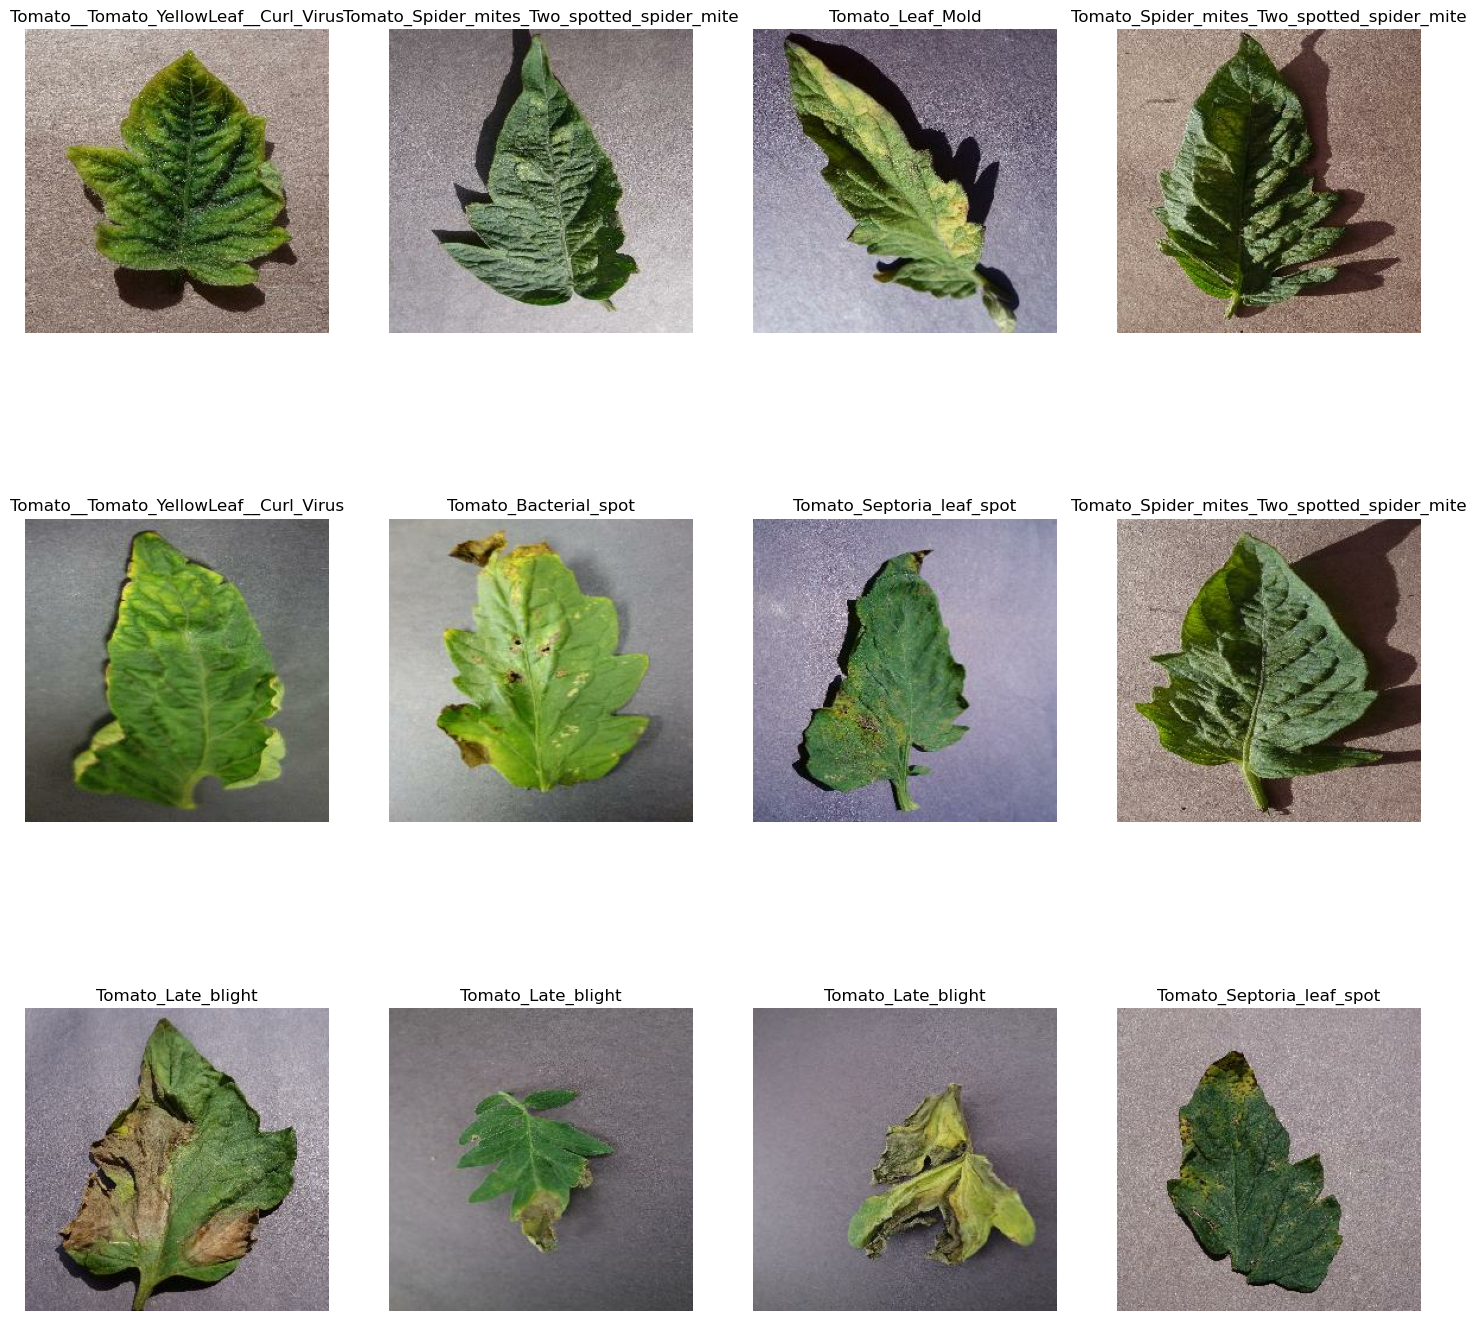

In [9]:
plt.figure(figsize=(18, 18))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):  # show only 12 images
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[int(label_batch[i].numpy())])  # fix label indexing
        plt.axis("off")

In [10]:
len(dataset)

501

In [11]:
train_size = 0.8
len(dataset)*train_size

400.8

In [12]:
train_ds = dataset.take(400)
len(train_ds)

400

In [13]:
test_ds = dataset.skip(400)
len(test_ds)

101

In [14]:
val_size = 0.1
len(dataset)*val_size

50.1

In [15]:
val_ds = test_ds.take(50)
len(val_ds)

50

In [16]:
test_ds = test_ds.skip(6)
len(test_ds)

95

In [17]:
def get_dataset_partitions_tf(ds, train_split = 0.8, val_split = 0.1, test_split = 0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 12)
        
    train_size = int (train_split * ds_size)
    val_size = int (val_split * ds_size)

    train_ds = ds.take(train_size)

    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).take(val_size)
    return train_ds, val_ds, test_ds

In [18]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [19]:
len(train_ds)

400

In [20]:
len(val_ds)

50

In [21]:
len(test_ds)

50

In [22]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [23]:
from tensorflow.keras import layers
resize_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

In [44]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),  # flip both ways
    layers.RandomRotation(0.2),                    # rotate up to 20%
    layers.RandomZoom(0.2),                        # zoom in/out by 20%
    layers.RandomContrast(0.2),                    # adjust contrast ±20%
    layers.RandomTranslation(0.1, 0.1)              # shift width/height by 10%
])

In [45]:
from tensorflow.keras import layers, models

n_classes = 10
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)  # include 3 channels (RGB)

# --- Model architecture ---
model = models.Sequential([
    resize_rescale,
    data_augmentation,
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),    
])

model.build(input_shape=input_shape)

In [46]:
model.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_10 (Sequential)           │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_30 (Conv2D)                   │ (32, 254, 254, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_30 (MaxPooling2D)      │ (32, 127, 127, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_31 (Conv2D)                   │ (32, 125, 125, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_31 (MaxPooling2D)      │ (32, 62, 62, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_32 (Conv2D)                   │ (32, 60, 60, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_32 (MaxPooling2D)      │ (32, 30, 30, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_33 (Conv2D)                   │ (32, 28, 28, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_33 (MaxPooling2D)      │ (32, 14, 14, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_34 (Conv2D)                   │ (32, 12, 12, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_34 (MaxPooling2D)      │ (32, 6, 6, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (32, 2304)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (32, 64)                    │         147,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (32, 10)                    │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 278,346 (1.06 MB)

 Trainable params: 278,346 (1.06 MB)

 Non-trainable params: 0 (0.00 B)

In [47]:
# --- Compile the model ---
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [48]:
# --- Train the model ---
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 777s 2s/step - accuracy: 0.3212 - loss: 1.8843 - val_accuracy: 0.5700 - val_loss: 1.2832
Epoch 2/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 746s 2s/step - accuracy: 0.5969 - loss: 1.1591 - val_accuracy: 0.4825 - val_loss: 2.4100
Epoch 3/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 578s 1s/step - accuracy: 0.7290 - loss: 0.7628 - val_accuracy: 0.5638 - val_loss: 1.5962
Epoch 4/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 417s 1s/step - accuracy: 0.7967 - loss: 0.5878 - val_accuracy: 0.7312 - val_loss: 1.0021
Epoch 5/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 426s 1s/step - accuracy: 0.8296 - loss: 0.4840 - val_accuracy: 0.6100 - val_loss: 1.8481
Epoch 6/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 410s 1s/step - accuracy: 0.8466 - loss: 0.4313 - val_accuracy: 0.7125 - val_loss: 1.1470
Epoch 7/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 418s 1s/step - accuracy: 0.8646 - loss: 0.3788 - val_accuracy: 0.6162 - val_loss: 1.9677
Epoch 8/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 411s 1s/step - accuracy: 0.8820 - loss: 0.3315 - val_accu

In [49]:
scores = model.evaluate(test_ds)

50/50 ━━━━━━━━━━━━━━━━━━━━ 164s 575ms/step - accuracy: 0.9510 - loss: 0.1506


In [50]:
scores

[0.1494375765323639, 0.9524999856948853]

In [51]:
history

In [52]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 400}

In [53]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [55]:
history.history['accuracy']

[0.4059374928474426,
 0.6469531059265137,
 0.7426562309265137,
 0.8050781488418579,
 0.8321093916893005,
 0.8550000190734863,
 0.8723437786102295,
 0.8890625238418579,
 0.8887500166893005,
 0.90625,
 0.9182812571525574,
 0.9092968702316284,
 0.9310937523841858,
 0.922656238079071,
 0.9339062571525574,
 0.9354687333106995,
 0.9327343702316284,
 0.9434375166893005,
 0.9474218487739563,
 0.942578136920929,
 0.9499218463897705,
 0.9491406083106995,
 0.946484386920929,
 0.953125,
 0.953906238079071,
 0.9574218988418579,
 0.9551562666893005,
 0.9574999809265137,
 0.9533593654632568,
 0.9560937285423279,
 0.964062511920929,
 0.9617968797683716,
 0.9641406536102295,
 0.9649999737739563,
 0.9631249904632568,
 0.9630468487739563,
 0.9624999761581421,
 0.9691406488418579,
 0.9652343988418579,
 0.9711718559265137,
 0.9700781106948853,
 0.9671875238418579,
 0.9703906178474426,
 0.9664062261581421,
 0.9686718583106995,
 0.9715625047683716,
 0.9700781106948853,
 0.9750000238418579,
 0.965781271457672

In [56]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

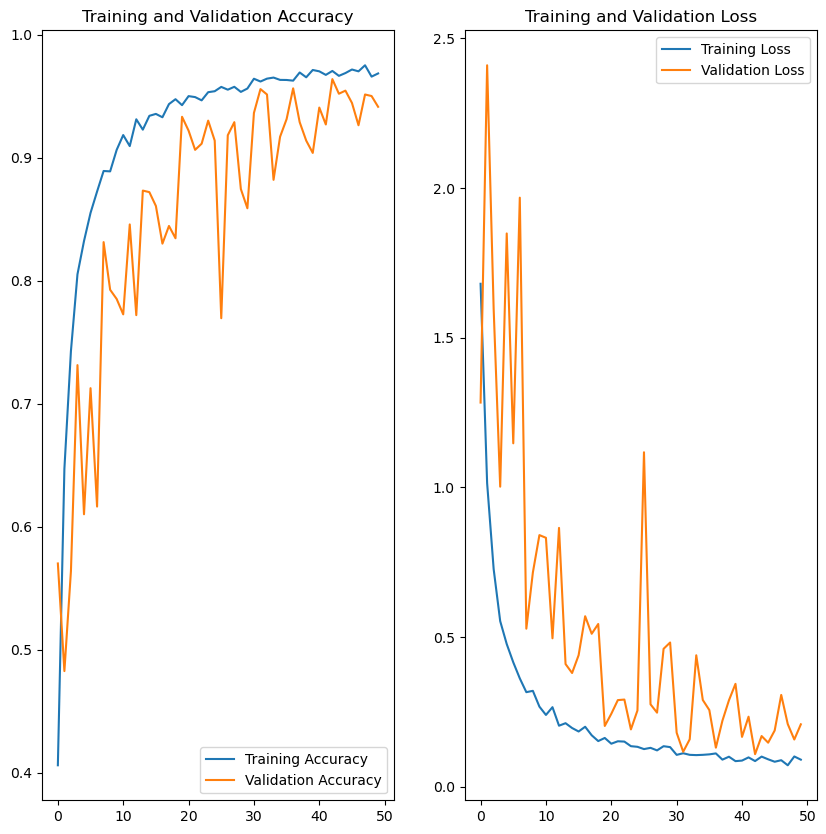

In [58]:
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label = 'Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label = 'Training Loss')
plt.plot(range(EPOCHS), val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.show()

In [80]:
np.argmax([6.7133916e-04, 1.7726888e-04, 9.9439973e-01, 3.0831576e-05,
       6.7915513e-05, 4.7578726e-07, 1.3232903e-05, 1.8418611e-03,
       5.8738969e-08, 2.7972588e-03])

2

First image to predict


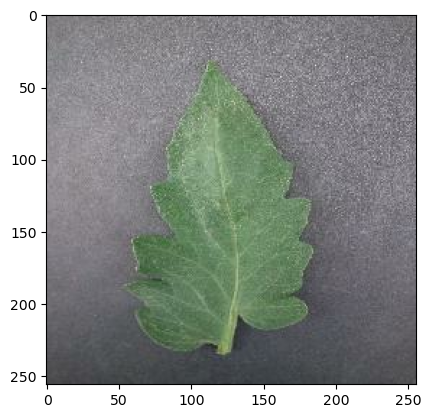

Actual label: Tomato_healthy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step
[1.0681597e-06 1.3653349e-06 4.6884357e-03 1.1212221e-04 1.4563245e-06
 1.8824872e-05 6.5189647e-07 2.5140439e-06 1.3214615e-06 9.9517220e-01]
Predicted label: Tomato_healthy


In [84]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype("uint8")
    first_label = labels_batch[0].numpy()

    print("First image to predict")
    plt.imshow(first_image)
    #plt.axis("off")
    plt.show()

    print("Actual label:", class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print(batch_prediction[0])
    print("Predicted label:", class_names[np.argmax(batch_prediction[0])])

In [131]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)

    predicted_class = [class_names[np.argmax(predictions[0])]]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


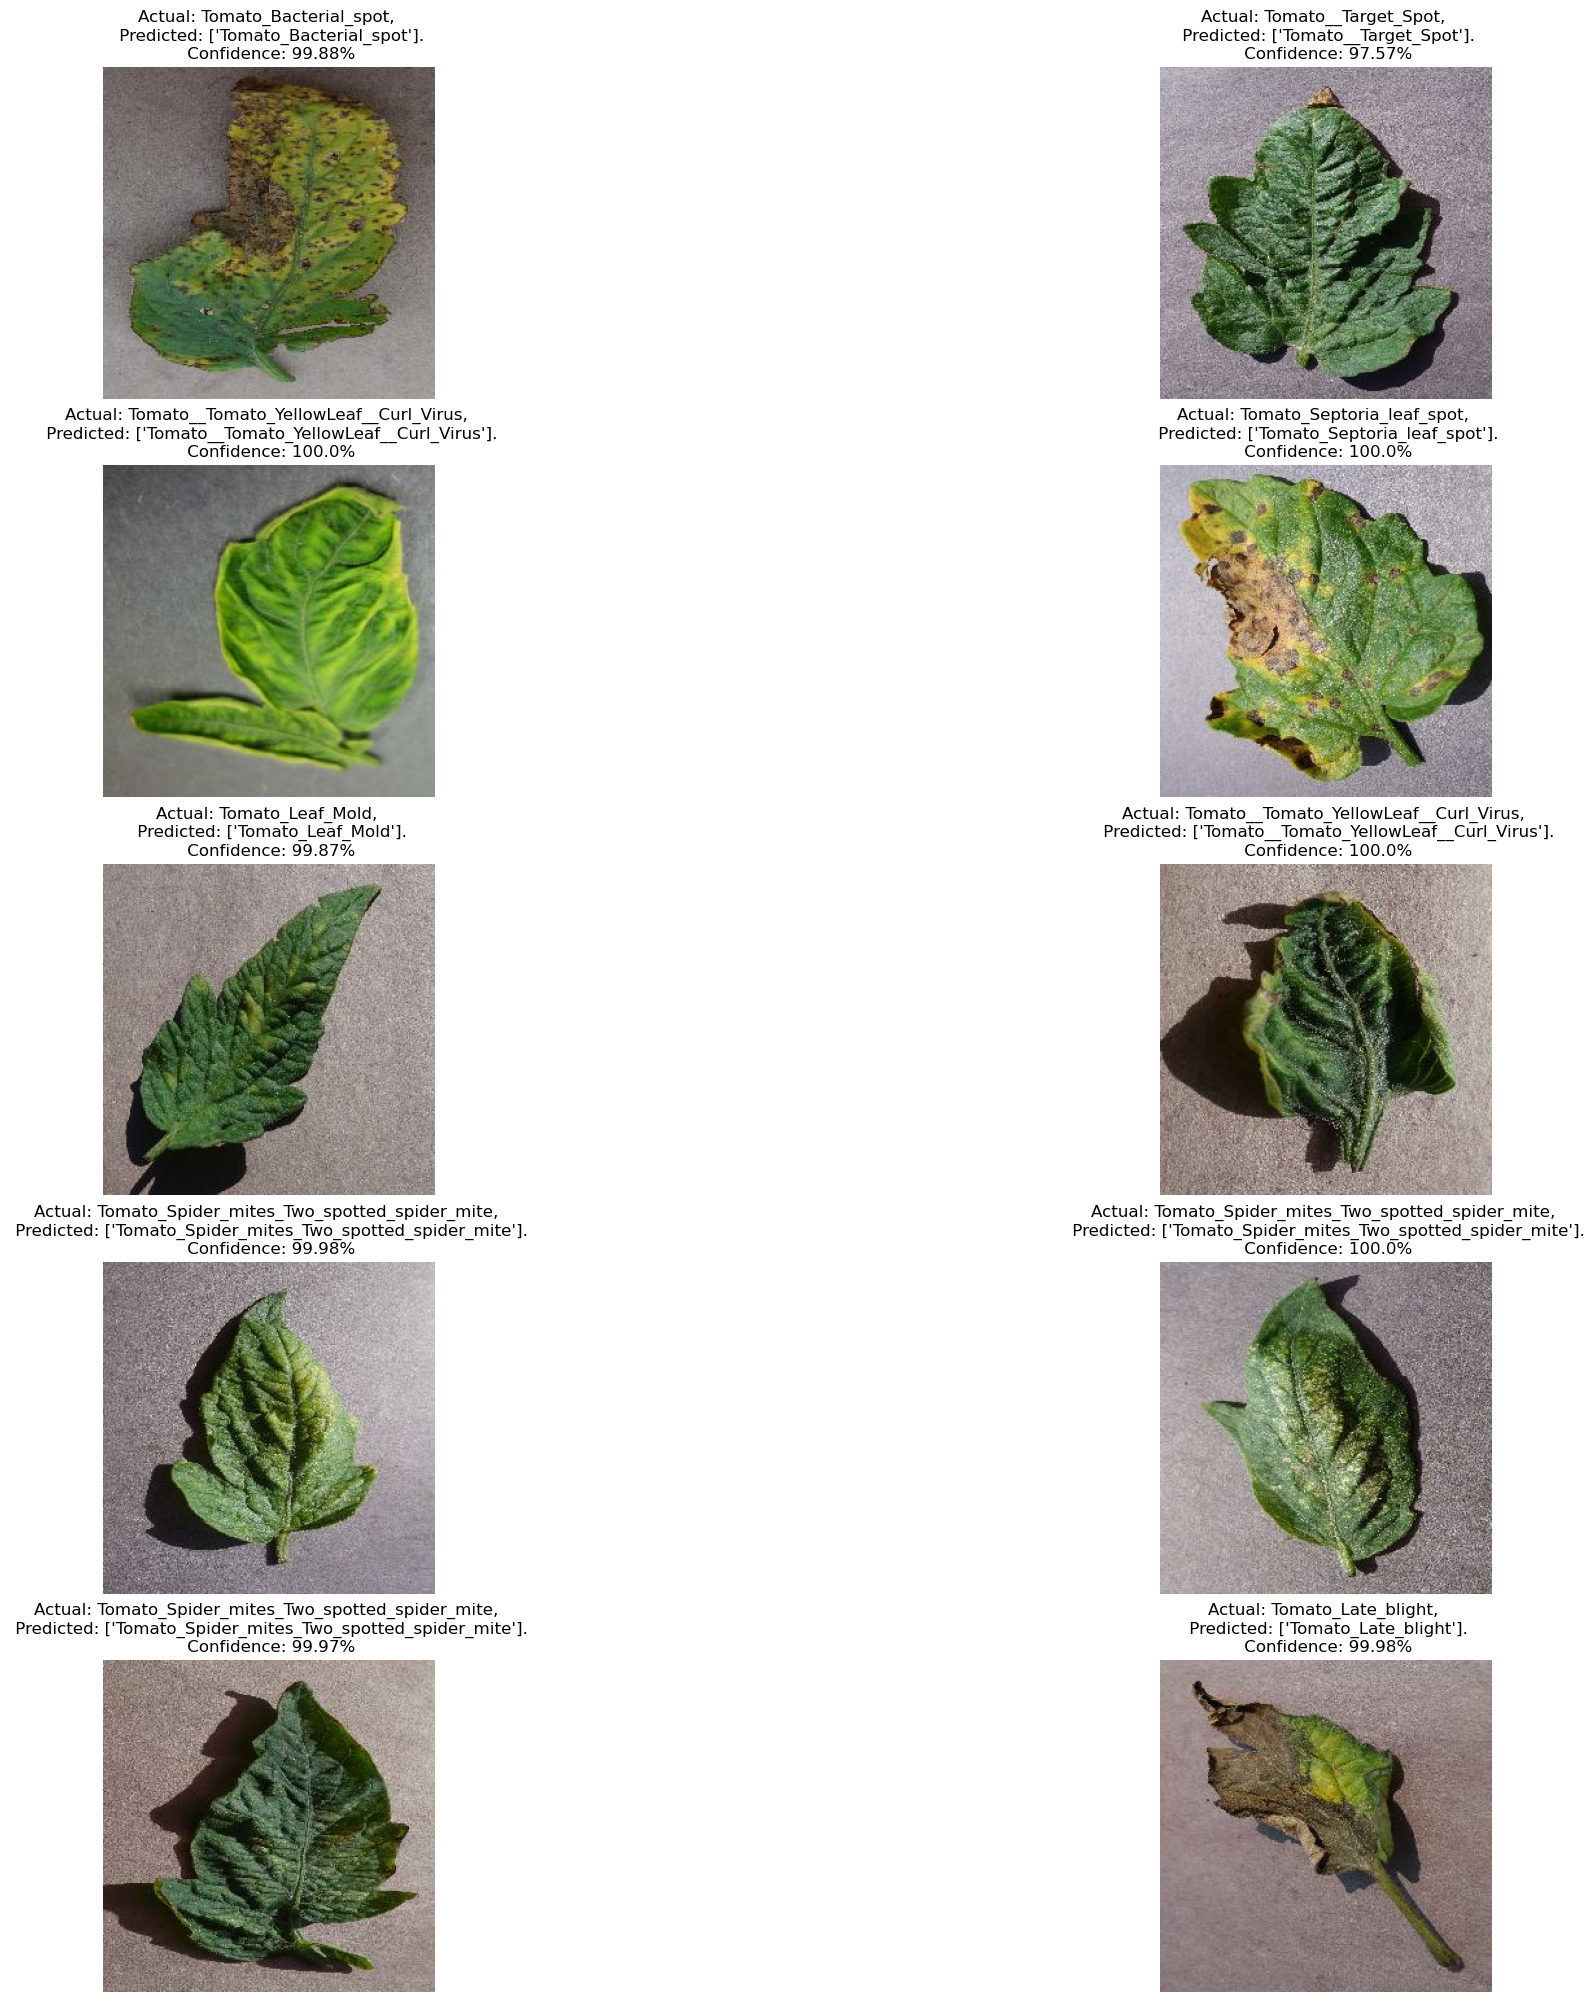

In [132]:
for images, labels in test_ds.take(1):
    plt.figure(figsize=(25,25))
    for i in range(10):
        ax = plt.subplot(5, 2, i+1)   # 5 rows, 2 cols
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

In [140]:
model_version = 2
model.export(f"../Saved Models/{model_version}")

INFO:tensorflow:Assets written to: ../Saved Models/2\assets


INFO:tensorflow:Assets written to: ../Saved Models/2\assets


Saved artifact at '../Saved Models/2'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='keras_tensor_172')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  2041723085520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2041723085328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2041723086096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2041723084752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2041723086480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2041723087440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2041723087824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2041723088592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2041723089168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2041723088400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2041723089936: TensorSpec(sh

In [143]:
import os
model_version = max([int(i) for i in os.listdir("../Saved Models") + [0]]) + 1
model.export(f"../Saved Models/{model_version}")

INFO:tensorflow:Assets written to: ../Saved Models/4\assets


INFO:tensorflow:Assets written to: ../Saved Models/4\assets


Saved artifact at '../Saved Models/4'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='keras_tensor_172')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  2041723085520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2041723085328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2041723086096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2041723084752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2041723086480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2041723087440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2041723087824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2041723088592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2041723089168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2041723088400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2041723089936: TensorSpec(sh